In [1]:
import random
import numpy as np
import numba as nb
from numba import jit
from math import log
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import rcParams, colors
import seaborn as sns
sns.set_style("whitegrid")

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import rcParams

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 7,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{dsfont}'}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 370.38374    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * ratio  # height in inches
fig_size = [fig_width, fig_height]
rcParams.update({'figure.figsize': fig_size})

Extract CDR3 sequences.

In [2]:
def extract_CDR3_sequences(path, N):
    
    data_dict_aminoacid = {}
    data_dict_nucleotides = {}

    it = 0
    with open(path) as f:
        for line in f:
            it += 1
            
            line = line.strip()
            values = line.split("\t")
            
            if it % 1000000 == 0:
                print("completed %1.2f%%"%(it/N*100))
            
            if values[0] in data_dict_aminoacid:
                data_dict_aminoacid[values[0]] += 1
            else:
                data_dict_aminoacid[values[0]] = 1

            if values[-1] in data_dict_nucleotides:
                data_dict_nucleotides[values[-1]] += 1
            else:
                data_dict_nucleotides[values[-1]] = 1
                
            if it == N:
                break
            
    return data_dict_aminoacid, data_dict_nucleotides

Generate TCR sets.

In [3]:
def TCR_sets(path, N_sequences, N_individuals):
    
    sets_aminoacid = []
    sets_nucleotides = []
    
    with open(path) as f:
        
        for i in range(N_individuals):
            it = 0
            set_aminoacid = []
            set_nucleotides = []
            
            for line in f:
                it += 1
                
                line = line.strip()
                values = line.split("\t")
                
                if values[0] not in sets_aminoacid:
                    set_aminoacid.append(values[0])
    
                if values[-1] not in sets_nucleotides:
                    set_nucleotides.append(values[-1])
                    
                if it == N_sequences:
                    sets_aminoacid.append(set_aminoacid)
                    sets_nucleotides.append(set_nucleotides)
                    break
        
    return sets_aminoacid, sets_nucleotides

In [4]:
sequences = extract_CDR3_sequences("human_TCR_300000.txt",300000)

In [5]:
sets_aminoacid, sets_nucleotides = TCR_sets("human_TCR_300000.txt",100000,3)

In [6]:
individual_1 = sets_aminoacid[0]
individual_2 = sets_aminoacid[1]
individual_3 = sets_aminoacid[2]

In [7]:
richness_aminoacid = (set(individual_1).union(set(individual_2))).union(set(individual_3))
aminoacids = np.array(list(richness_aminoacid))
richness_aminoacid = len(richness_aminoacid)

Richness using amino acid data.

In [8]:
richness_aminoacid

284598

Amino acids across all individuals.

In [9]:
aminoacids

array(['CASSFSSYNEQFF', 'CASSDDRNTIYF', 'CASSPHLSAAQPQHF', ...,
       'CASSSLGHIPSNQPQHF', 'CASSSVLYEQYF', 'CASSLKQTPWGQGATEAFF'],
      dtype='<U24')

In [10]:
dict_aminoacids = dict(zip(aminoacids,np.arange(0,len(aminoacids),1)))

In [11]:
counter_1 =  Counter(individual_1)
counter_2 =  Counter(individual_2)
counter_3 =  Counter(individual_3)

In [12]:
abundance_set1 = [x for x in counter_1.values()]
sequence_numbers_set1 = [dict_aminoacids[x] for x in counter_1.keys()]

abundance_set2 = [x for x in counter_2.values()]
sequence_numbers_set2 = [dict_aminoacids[x] for x in counter_2.keys()]

abundance_set3 = [x for x in counter_3.values()]
sequence_numbers_set3 = [dict_aminoacids[x] for x in counter_3.keys()]

Generate sampling probability arrays.

In [13]:
sampling_probs123 = np.zeros([3,richness_aminoacid])
sampling_probs12 = np.zeros([2,richness_aminoacid])
sampling_probs13 = np.zeros([2,richness_aminoacid])
sampling_probs23 = np.zeros([2,richness_aminoacid])

sampling_n123 = np.zeros([3,richness_aminoacid])
sampling_n12 = np.zeros([2,richness_aminoacid])
sampling_n13 = np.zeros([2,richness_aminoacid])
sampling_n23 = np.zeros([2,richness_aminoacid])

In [14]:
for i in range(richness_aminoacid):
    try:
        sampling_n123[0,i] = counter_1[aminoacids[i]]
        sampling_n123[1,i] = counter_2[aminoacids[i]]
        sampling_n123[2,i] = counter_3[aminoacids[i]]
        
        sampling_probs123[0,i] = sampling_n123[0,i]/1e5
        sampling_probs123[1,i] = sampling_n123[1,i]/1e5
        sampling_probs123[2,i] = sampling_n123[2,i]/1e5
    except:
        sampling_n123[0,i] = 0
        sampling_n123[1,i] = 0
        sampling_n123[2,i] = 0
        
        sampling_probs123[0,i] = 0
        sampling_probs123[1,i] = 0
        sampling_probs123[2,i] = 0
    
    try:
        sampling_n12[0,i] = counter_1[aminoacids[i]]
        sampling_n12[1,i] = counter_2[aminoacids[i]]
        
        sampling_probs12[0,i] = sampling_n12[0,i]/1e5
        sampling_probs12[1,i] = sampling_n12[1,i]/1e5
    except: 
        sampling_n12[0,i] = 0
        sampling_n12[1,i] = 0
        
        sampling_probs12[0,i] = 0
        sampling_probs12[1,i] = 0
        
    try:
        sampling_n13[0,i] = counter_1[aminoacids[i]]
        sampling_n13[1,i] = counter_3[aminoacids[i]]
        
        sampling_probs13[0,i] = sampling_n13[0,i]/1e5
        sampling_probs13[1,i] = sampling_n13[1,i]/1e5
    except:
        sampling_n13[0,i] = 0
        sampling_n13[1,i] = 0
        
        sampling_probs13[0,i] = 0
        sampling_probs13[1,i] = 0
        
    try: 
        sampling_n23[0,i] = counter_2[aminoacids[i]]
        sampling_n23[1,i] = counter_3[aminoacids[i]]
        
        sampling_probs23[0,i] = sampling_n23[0,i]/1e5
        sampling_probs23[1,i] = sampling_n23[1,i]/1e5
    except:
        sampling_n23[0,i] = 0
        sampling_n23[1,i] = 0
        
        sampling_probs23[0,i] = 0
        sampling_probs23[1,i] = 0

Define overlap function.

In [15]:
def overlap(set1,set2,set3,richness):
  relative_overlap_12 = len(set(set1.intersection(set2)))/richness
  relative_overlap_13 = len(set(set1.intersection(set3)))/richness
  relative_overlap_23 = len(set(set2.intersection(set3)))/richness
  relative_overlap_123 = len(set((set1.intersection(set2)).intersection(set3)))/richness

  return relative_overlap_12, relative_overlap_13, relative_overlap_23, relative_overlap_123

Compute expected overlaps.

In [16]:
@jit(nopython=True,parallel=True)
def moments_KM(Omega,M,p,N):
    
    KM = 0
    cross_terms_KM = 0
    
    for i in nb.prange(Omega):
        for j in range(i,Omega):
            product_i = 1
            product_ij = 1

            for m in range(M):
                
                if i == 0:
                    product_i *= (1-(1-p[m,j])**N)
                    
                if i != j:
                    product_ij *= 1+(1-p[m,i]-p[m,j])**N-(1-p[m,i])**N-(1-p[m,j])**N
            
            if i == 0:
                KM += product_i
            
            if i != j:
                cross_terms_KM += 2*product_ij
            
    expected_KM = KM
    variance_KM = expected_KM+cross_terms_KM-expected_KM**2
    
    return expected_KM, np.sqrt(variance_KM)

In [17]:
@jit(nopython=True,parallel=True)
def moments_KM_n(Omega,M,n,N,S):
    
    KM = 0
    cross_terms_KM = 0
    
    for i in nb.prange(Omega):
        for j in range(i,Omega):
            product_i = 1
            product_ij = 1

            for m in range(M):
                
                if i == 0:
                    product_i *= (1-(1+((S*(1+2*N-2*S))/(2*N*(N-S))+log(1-S/N))*n[m,j])*(1-n[m,j]/N)**S)
                    
                if i != j:
                    product_ij *= 1+(1+((S*(1+2*N-2*S))/(2*N*(N-S))+log(1-S/N))*(n[m,i]+n[m,j]))*(1-(n[m,i]+n[m,j])/N)**S-\
                    (1+((S*(1+2*N-2*S))/(2*N*(N-S))+log(1-S/N))*n[m,i])*(1-n[m,i]/N)**S-\
                    (1+((S*(1+2*N-2*S))/(2*N*(N-S))+log(1-S/N))*n[m,j])*(1-n[m,j]/N)**S
            
            if i == 0:
                KM += product_i
            
            if i != j:
                cross_terms_KM += 2*product_ij
            
    expected_KM = KM
    variance_KM = expected_KM+cross_terms_KM-expected_KM**2
    
    return expected_KM, np.sqrt(variance_KM), cross_terms_KM

In [18]:
def sort_lists(list1,list2):
    
    zipped_lists = zip(list1, list2)
    sorted_pairs = sorted(zipped_lists)
    tuples = zip(*sorted_pairs)
    list1, list2 = [list(tuple) for tuple in  tuples]
    
    return list1, list2

In [20]:
sample_size_arr = np.arange(10,35000,2500)
arr12_n = [moments_KM_n(richness_aminoacid,2,sampling_n12,1e5,S) for S in sample_size_arr]
arr13_n = [moments_KM_n(richness_aminoacid,2,sampling_n13,1e5,S) for S in sample_size_arr]
arr23_n = [moments_KM_n(richness_aminoacid,2,sampling_n23,1e5,S) for S in sample_size_arr]
arr123_n = [moments_KM_n(richness_aminoacid,3,sampling_n123,1e5,S) for S in sample_size_arr]

In [21]:
arr12 = [moments_KM(richness_aminoacid,2,sampling_probs12,N) for N in sample_size_arr]
arr13 = [moments_KM(richness_aminoacid,2,sampling_probs13,N) for N in sample_size_arr]
arr23 = [moments_KM(richness_aminoacid,2,sampling_probs23,N) for N in sample_size_arr]
arr123 = [moments_KM(richness_aminoacid,3,sampling_probs123,N) for N in sample_size_arr]

In [22]:
np.savetxt("empirical_sampling.csv",np.c_[arr12_n,arr13_n,arr23_n,arr123_n,arr12,arr13,arr23,arr123],header="12 n 13 n 23 n 123 n 12 13 23 123")

Plot abundance and overlaps for different sample sizes.

<ipython-input-26-35d1a5b91a22>:115: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


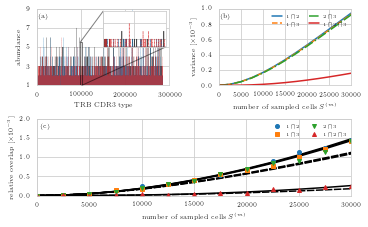

In [26]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AB
    CC
    """
)

list1, list2 = sort_lists(sequence_numbers_set1,abundance_set1)
axd["A"].plot(list1, list2,color="k",linewidth=0.2,alpha=0.7)
list1, list2 = sort_lists(sequence_numbers_set2,abundance_set2)
axd["A"].plot(list1, list2,color="tab:blue",linewidth=0.2,alpha=0.7,linestyle=(0, (5, 1)))
list1, list2 = sort_lists(sequence_numbers_set3,abundance_set3)
axd["A"].plot(list1, list2,color="tab:red",linewidth=0.2,alpha=0.7,linestyle=(0, (3, 1, 1, 1)))
axd["A"].text(0.01*300000,0.88*8+1,r"(a)")

axd["A"].set_xlim(0,300000)
axd["A"].set_xticks([0,1e5,2e5,3e5])
axd["A"].set_ylim(1,9)
axd["A"].set_yticks([1,3,5,7,9])
axd["A"].set_xlabel(r"TRB CDR3 type")
axd["A"].set_ylabel(r"abundance")

# inset axes....
axins = axd["A"].inset_axes([0.5, 0.5, 0.47, 0.47])
list1, list2 = sort_lists(sequence_numbers_set1,abundance_set1)
axins.plot(list1, list2,color="k",linewidth=0.6,alpha=0.7)
list1, list2 = sort_lists(sequence_numbers_set2,abundance_set2)
axins.plot(list1, list2,color="tab:blue",linewidth=0.6,alpha=0.7,linestyle=(0, (5, 1)))
list1, list2 = sort_lists(sequence_numbers_set3,abundance_set3)
axins.plot(list1, list2,color="tab:red",linewidth=0.6,alpha=0.7,linestyle=(0, (3, 1, 1, 1)))

# sub region of the original image
axins.set_xlim(98000, 102000)
axins.set_ylim(1, 5.5)
axins.set_xticklabels([])
axins.set_yticklabels([])

axd["A"].indicate_inset_zoom(axins, edgecolor="black")

relative_overlap_12_arr = []
relative_overlap_13_arr = []
relative_overlap_23_arr = []
relative_overlap_123_arr = []
sample_size_arr = np.arange(10,35000,2500)

for sample_size in sample_size_arr:
  sample1 = random.sample(individual_1,sample_size)
  sample2 = random.sample(individual_2,sample_size)
  sample3 = random.sample(individual_3,sample_size)
  set1 = set(sample1)
  set2 = set(sample2)
  set3 = set(sample3)

  relative_overlap_12, relative_overlap_13, relative_overlap_23, relative_overlap_123 = overlap(set1,set2,set3,richness_aminoacid)
  relative_overlap_12_arr.append(1e3*relative_overlap_12)
  relative_overlap_13_arr.append(1e3*relative_overlap_13)
  relative_overlap_23_arr.append(1e3*relative_overlap_23)
  relative_overlap_123_arr.append(1e3*relative_overlap_123)

#arr = [moments_KM(richness_aminoacid,2,sampling_probs12,N) for N in sample_size_arr]
axd["C"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr12],linewidth=1.5,ls=(0, (5, 1)),color='k')
axd["C"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr12_n],linewidth=1.5,color='k')
#axd["C"].fill_between(sample_size_arr,
#                   [1e3*(arr12[i][0]-arr12[i][1])/richness_aminoacid for i in range(len(arr12))],
#                   [1e3*(arr12[i][0]+arr12[i][1])/richness_aminoacid for i in range(len(arr12))],facecolor="Grey",alpha=0.5)

axd["B"].plot(sample_size_arr,[1e3*x[1]**2/richness_aminoacid for x in arr12],label=r"$1\bigcap 2$")

#arr = [moments_KM(richness_aminoacid,2,sampling_probs13,N) for N in sample_size_arr]
axd["C"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr13],linewidth=1.5,ls=(0, (5, 1)),color='k')
axd["C"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr13_n],linewidth=1.5,color='k')
#axd["C"].fill_between(sample_size_arr,
#                   [1e3*(arr13[i][0]-arr13[i][1])/richness_aminoacid for i in range(len(arr13))],
#                   [1e3*(arr13[i][0]+arr13[i][1])/richness_aminoacid for i in range(len(arr13))],facecolor="Grey",alpha=0.5)

axd["B"].plot(sample_size_arr,[1e3*x[1]**2/richness_aminoacid for x in arr13],ls="--",label=r"$1\bigcap 3$")

#arr = [moments_KM(richness_aminoacid,2,sampling_probs23,N) for N in sample_size_arr]
axd["C"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr23],linewidth=1.5,ls=(0, (5, 1)),color='k')
axd["C"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr23_n],linewidth=1.5,color='k')
#axd["C"].fill_between(sample_size_arr,
#                   [1e3*(arr23[i][0]-arr23[i][1])/richness_aminoacid for i in range(len(arr23))],
#                   [1e3*(arr23[i][0]+arr23[i][1])/richness_aminoacid for i in range(len(arr23))],facecolor="Grey",alpha=0.5)

axd["B"].plot(sample_size_arr,[1e3*x[1]**2/richness_aminoacid for x in arr23],ls="-.",label=r"$2\bigcap 3$")

#arr = [moments_KM(richness_aminoacid,3,sampling_probs123,N) for N in sample_size_arr]
axd["C"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr123],linewidth=1.5,ls=(0, (5, 1)),color='k')
axd["C"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr123_n],linewidth=1.5,color='k')
#axd["C"].fill_between(sample_size_arr,
#                   [1e3*(arr123[i][0]-arr123[i][1])/richness_aminoacid for i in range(len(arr123))],
#                   [1e3*(arr123[i][0]+arr123[i][1])/richness_aminoacid for i in range(len(arr123))],facecolor="Grey",alpha=0.5)

axd["B"].plot(sample_size_arr,[1e3*x[1]**2/richness_aminoacid for x in arr123],label=r"$1\bigcap 2\bigcap 3$")

axd["C"].plot(sample_size_arr,relative_overlap_12_arr,'o',label=r"$1\bigcap 2$",markersize=4)
axd["C"].plot(sample_size_arr,relative_overlap_13_arr,'s',label=r"$1\bigcap 3$",markersize=4)
axd["C"].plot(sample_size_arr,relative_overlap_23_arr,'v',label=r"$2\bigcap 3$",markersize=4)
axd["C"].plot(sample_size_arr,relative_overlap_123_arr,'^',label=r"$1\bigcap 2\bigcap 3$",markersize=4)
axd["C"].text(0.01*30000,0.88*2,r"(c)")

axd["C"].legend(loc=1,ncol=2,fontsize=5,frameon=False)
axd["C"].set_xlim(0,30000)
axd["C"].set_ylim(0,2)
axd["C"].set_xlabel(r"number of sampled cells $S^{(m)}$")
axd["C"].set_ylabel(r"relative overlap [$\times 10^{-3}$]")

axd["B"].text(0.01*30000,0.88*1,r"(b)")
axd["B"].legend(loc=1,ncol=2,fontsize=5,frameon=False)
axd["B"].set_xlim(0,30000)
axd["B"].set_ylim(0,1)
axd["B"].set_xlabel(r"number of sampled cells $S^{(m)}$")
axd["B"].set_ylabel(r"variance $[\times 10^{-3}]$")

plt.tight_layout()
plt.savefig("overlap_sampling_empirical.svg",dpi=300)
plt.show()

In [23]:
richness_aminoacid

284598

<ipython-input-35-4bb28b238eff>:115: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


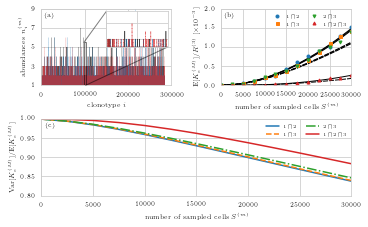

In [35]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AB
    CC
    """
)

list1, list2 = sort_lists(sequence_numbers_set1,abundance_set1)
axd["A"].plot(list1, list2,color="k",linewidth=0.2,alpha=0.7)
list1, list2 = sort_lists(sequence_numbers_set2,abundance_set2)
axd["A"].plot(list1, list2,color="tab:blue",linewidth=0.2,alpha=0.7,linestyle=(0, (5, 1)))
list1, list2 = sort_lists(sequence_numbers_set3,abundance_set3)
axd["A"].plot(list1, list2,color="tab:red",linewidth=0.2,alpha=0.7,linestyle=(0, (3, 1, 1, 1)))
axd["A"].text(0.02*300000,0.9*8+1,r"(a)")

axd["A"].set_xlim(0,300000)
axd["A"].set_xticks([0,1e5,2e5,3e5])
axd["A"].set_ylim(1,9)
axd["A"].set_yticks([1,3,5,7,9])
axd["A"].set_xlabel(r"clonotype $i$")
axd["A"].set_ylabel(r"abundances $n_i^{(m)}$")

# inset axes....
axins = axd["A"].inset_axes([0.5, 0.5, 0.47, 0.47])
list1, list2 = sort_lists(sequence_numbers_set1,abundance_set1)
axins.plot(list1, list2,color="k",linewidth=0.6,alpha=0.7)
list1, list2 = sort_lists(sequence_numbers_set2,abundance_set2)
axins.plot(list1, list2,color="tab:blue",linewidth=0.6,alpha=0.7,linestyle=(0, (5, 1)))
list1, list2 = sort_lists(sequence_numbers_set3,abundance_set3)
axins.plot(list1, list2,color="tab:red",linewidth=0.6,alpha=0.7,linestyle=(0, (3, 1, 1, 1)))

# sub region of the original image
axins.set_xlim(98000, 102000)
axins.set_ylim(1, 5.5)
axins.set_xticklabels([])
axins.set_yticklabels([])

axd["A"].indicate_inset_zoom(axins, edgecolor="black")

relative_overlap_12_arr = []
relative_overlap_13_arr = []
relative_overlap_23_arr = []
relative_overlap_123_arr = []
sample_size_arr = np.arange(10,35000,2500)

for sample_size in sample_size_arr:
  sample1 = random.sample(individual_1,sample_size)
  sample2 = random.sample(individual_2,sample_size)
  sample3 = random.sample(individual_3,sample_size)
  set1 = set(sample1)
  set2 = set(sample2)
  set3 = set(sample3)

  relative_overlap_12, relative_overlap_13, relative_overlap_23, relative_overlap_123 = overlap(set1,set2,set3,richness_aminoacid)
  relative_overlap_12_arr.append(1e3*relative_overlap_12)
  relative_overlap_13_arr.append(1e3*relative_overlap_13)
  relative_overlap_23_arr.append(1e3*relative_overlap_23)
  relative_overlap_123_arr.append(1e3*relative_overlap_123)

#arr = [moments_KM(richness_aminoacid,2,sampling_probs12,N) for N in sample_size_arr]
axd["B"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr12],linewidth=1.0,ls=(0, (5, 1)),color='k')
axd["B"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr12_n],linewidth=1.0,color='k')
#axd["C"].fill_between(sample_size_arr,
#                   [1e3*(arr12[i][0]-arr12[i][1])/richness_aminoacid for i in range(len(arr12))],
#                   [1e3*(arr12[i][0]+arr12[i][1])/richness_aminoacid for i in range(len(arr12))],facecolor="Grey",alpha=0.5)

axd["C"].plot(sample_size_arr,[x[1]**2/x[0] for x in arr12],label=r"$1\bigcap 2$")

#arr = [moments_KM(richness_aminoacid,2,sampling_probs13,N) for N in sample_size_arr]
axd["B"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr13],linewidth=1.0,ls=(0, (5, 1)),color='k')
axd["B"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr13_n],linewidth=1.0,color='k')
#axd["C"].fill_between(sample_size_arr,
#                   [1e3*(arr13[i][0]-arr13[i][1])/richness_aminoacid for i in range(len(arr13))],
#                   [1e3*(arr13[i][0]+arr13[i][1])/richness_aminoacid for i in range(len(arr13))],facecolor="Grey",alpha=0.5)

axd["C"].plot(sample_size_arr,[x[1]**2/x[0] for x in arr13],ls="--",label=r"$1\bigcap 3$")

#arr = [moments_KM(richness_aminoacid,2,sampling_probs23,N) for N in sample_size_arr]
axd["B"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr23],linewidth=1.0,ls=(0, (5, 1)),color='k')
axd["B"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr23_n],linewidth=1.0,color='k')
#axd["C"].fill_between(sample_size_arr,
#                   [1e3*(arr23[i][0]-arr23[i][1])/richness_aminoacid for i in range(len(arr23))],
#                   [1e3*(arr23[i][0]+arr23[i][1])/richness_aminoacid for i in range(len(arr23))],facecolor="Grey",alpha=0.5)

axd["C"].plot(sample_size_arr,[x[1]**2/x[0] for x in arr23],ls="-.",label=r"$2\bigcap 3$")

#arr = [moments_KM(richness_aminoacid,3,sampling_probs123,N) for N in sample_size_arr]
axd["B"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr123],linewidth=1.0,ls=(0, (5, 1)),color='k')
axd["B"].plot(sample_size_arr,[1e3*x[0]/richness_aminoacid for x in arr123_n],linewidth=1.0,color='k')
#axd["C"].fill_between(sample_size_arr,
#                   [1e3*(arr123[i][0]-arr123[i][1])/richness_aminoacid for i in range(len(arr123))],
#                   [1e3*(arr123[i][0]+arr123[i][1])/richness_aminoacid for i in range(len(arr123))],facecolor="Grey",alpha=0.5)

axd["C"].plot(sample_size_arr,[x[1]**2/x[0] for x in arr123],label=r"$1\bigcap 2\bigcap 3$")

axd["B"].plot(sample_size_arr,relative_overlap_12_arr,'o',label=r"$1\bigcap 2$",markersize=3)
axd["B"].plot(sample_size_arr,relative_overlap_13_arr,'s',label=r"$1\bigcap 3$",markersize=3)
axd["B"].plot(sample_size_arr,relative_overlap_23_arr,'v',label=r"$2\bigcap 3$",markersize=3)
axd["B"].plot(sample_size_arr,relative_overlap_123_arr,'^',label=r"$1\bigcap 2\bigcap 3$",markersize=3)
axd["B"].text(0.02*30000,0.9*2,r"(b)")

axd["B"].legend(loc=1,ncol=2,fontsize=5,frameon=False)
axd["B"].set_xlim(0,30000)
axd["B"].set_ylim(0,2)
axd["B"].set_xlabel(r"number of sampled cells $S^{(m)}$")
axd["B"].set_ylabel(r"$\mathds{E}[K_{\rm s}^{(M)}]/R^{(3)}$ [$\times 10^{-3}$]")

axd["C"].text(0.01*30000,0.9*0.2+0.8,r"(c)")
axd["C"].legend(loc=1,ncol=2,fontsize=5,frameon=False,handlelength=2.6)
axd["C"].set_xlim(0,30000)
axd["C"].set_ylim(0.8,1)
axd["C"].set_xlabel(r"number of sampled cells $S^{(m)}$")
axd["C"].set_ylabel(r"$\mathrm{Var}[K_{\rm s}^{(M)}]/\mathds{E}[K_{\rm s}^{(M)}]$")

plt.tight_layout()
plt.savefig("overlap_sampling_empirical_fano.svg",dpi=300)
plt.show()